In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA as sklearnPCA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv(r"C:\Users\hibag\Downloads\archive\train_0irEZ2H.csv", encoding='ISO-8859-1', sep=',')
df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


# Data Transformation

In [3]:
df = df.drop(columns=['is_featured_sku', 'is_display_sku'])
df = df.rename(columns={'sku_id': 'product_id'})

In [4]:
product_catalog = [
    "Milk 1L",
    "Bread White",
    "Bread Whole Wheat",
    "Pasta 500g",
    "Rice 1kg",
    "Olive Oil 1L",
    "Sugar 1kg",
    "Salt 1kg",
    "Tomato Sauce",
    "Canned Tuna",
    "Yogurt Pack",
    "Cheese 200g",
    "Butter 250g",
    "Eggs 12-pack",
    "Chicken Breast",
    "Beef Mince",
    "Apples 1kg",
    "Bananas 1kg",
    "Orange Juice 1L",
    "Mineral Water 1.5L",
    "Soft Drink 1.5L",
    "Chocolate Bar",
    "Biscuits Pack",
    "Breakfast Cereal",
    "Coffee 250g",
    "Tea Box",
    "Shampoo 250ml",
    "Soap Bar",
    "Laundry Detergent",
    "Dishwashing Liquid"
]


In [5]:
unique_products = df['product_id'].unique()

np.random.seed(42)  # ensures reproducibility

product_name_map = {
    pid: product_catalog[i % len(product_catalog)]
    for i, pid in enumerate(unique_products)
}

df['product_name'] = df['product_id'].map(product_name_map)
#df[['product_id', 'product_name']].drop_duplicates().head(10)

In [6]:
cols = df.columns.tolist()

# remove product_name from its current position
cols.remove('product_name')

# find index of product_id and insert product_name right after it
product_id_index = cols.index('product_id')
cols.insert(product_id_index + 1, 'product_name')

# reorder dataframe
df = df[cols]

In [7]:
df['week'] = pd.to_datetime(df['week'], format='%d/%m/%y')

In [8]:
df['discount'] = df['base_price'] - df['total_price']


In [9]:

# 1. Rename 'week' to 'date'
df = df.rename(columns={'week': 'date'})

# 2. Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# 3. Sort by date
df = df.sort_values('date')

# 4. Create sequential week labels
df['week'] = (
    'Week ' +
    (
        df['date'].dt.to_period('W')
        .ne(df['date'].dt.to_period('W').shift())
        .cumsum()
    ).astype(str)
)


df

,record_ID,date,store_id,product_id,product_name,total_price,base_price,units_sold,discount,week
0,1,2011-01-17,8091,216418,Milk 1L,99.0375,111.8625,20,12.825,Week 1
774,1097,2011-01-17,9672,223153,Tomato Sauce,192.3750,236.5500,109,44.175,Week 1
773,1096,2011-01-17,9672,223245,Salt 1kg,207.3375,207.3375,61,0.000,Week 1
772,1095,2011-01-17,9672,222765,Chicken Breast,241.5375,241.5375,49,0.000,Week 1
771,1094,2011-01-17,9672,222087,Cheese 200g,181.6875,207.3375,129,25.650,Week 1
...,...,...,...,...,...,...,...,...,...,...
149376,211531,2013-07-09,9112,216419,Bread White,109.7250,109.7250,137,0.000,Week 130
149375,211530,2013-07-09,9112,216418,Milk 1L,110.4375,110.4375,162,0.000,Week 130
149374,211529,2013-07-09,9092,546789,Breakfast Cereal,234.4125,234.4125,13,0.000,Week 130
149426,211609,2013-07-09,9164,320485,Butter 250g,213.0375,213.0375,19,0.000,Week 130


# EDA: Exploratory Data Analysis

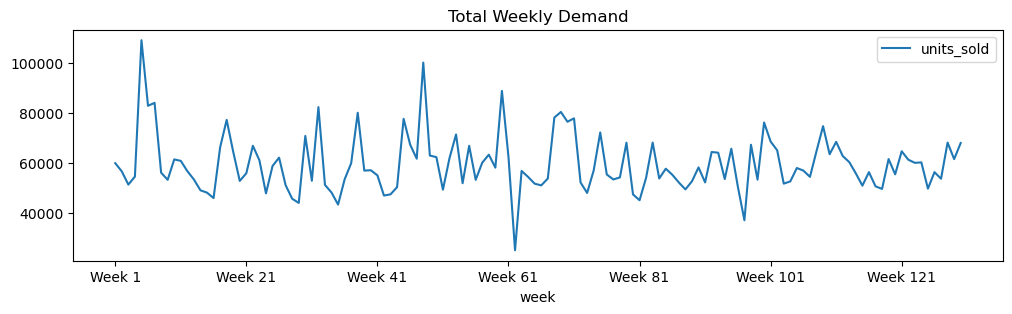

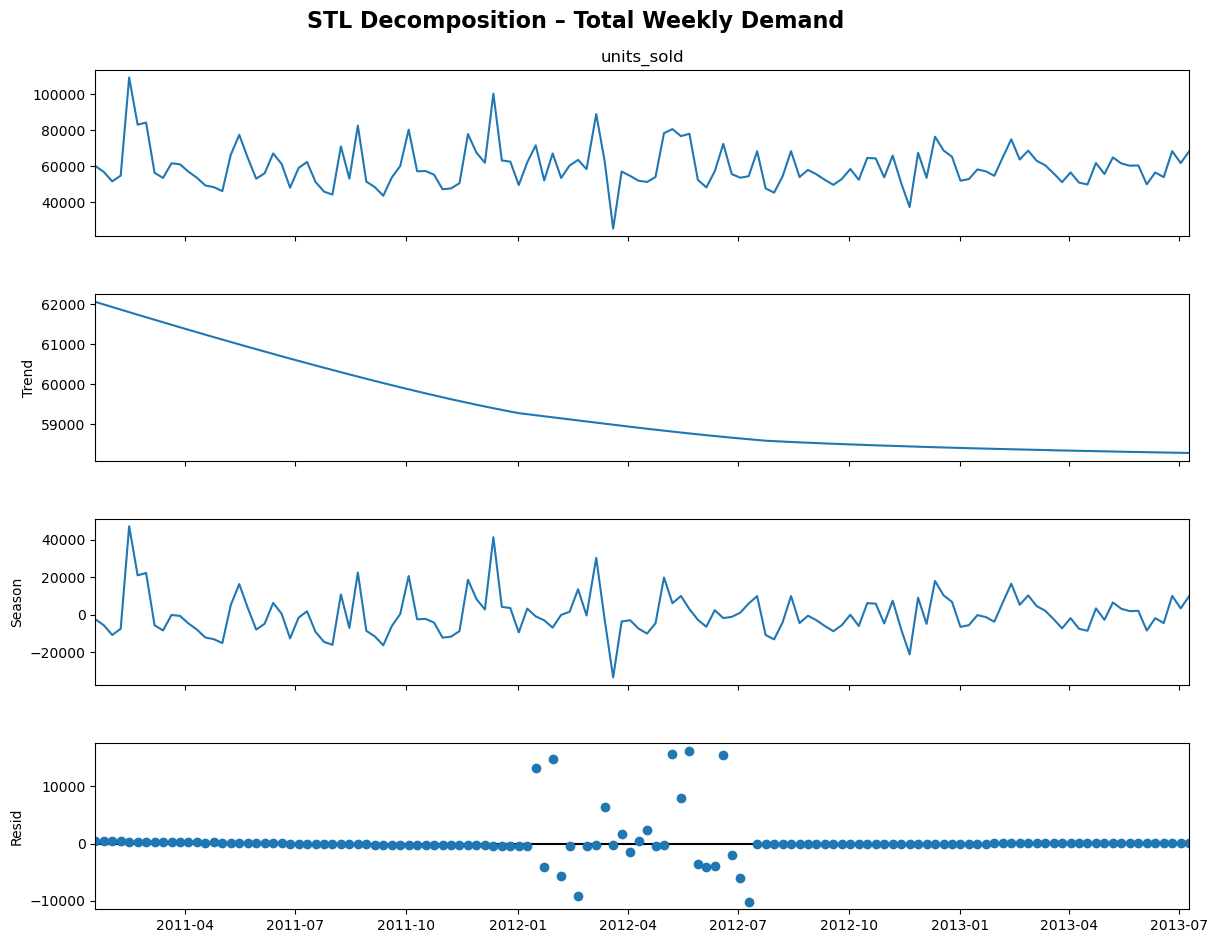

In [10]:
weekly_demand = (
    df.groupby('week')['units_sold']
      .sum()
      .reset_index()
)

weekly_demand['week_num'] = weekly_demand['week'].str.extract(r'(\d+)').astype(int)

weekly_demand = weekly_demand.sort_values('week_num')

weekly_demand.plot(
    x='week',
    y='units_sold',
    figsize=(12,3),
    title='Total Weekly Demand'
)

from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Aggregate weekly demand
ts = (
    df.groupby('date')['units_sold']
      .sum()
)

# STL decomposition
stl = STL(ts, period=52, robust=True)
result = stl.fit()

# Plot with better spacing
fig = result.plot()

# Increase figure size
fig.set_size_inches(14, 10)

# Adjust spacing between subplots
plt.subplots_adjust(
    top=0.92,
    hspace=0.35
)

# Main title
fig.suptitle(
    "STL Decomposition – Total Weekly Demand",
    fontsize=16,
    fontweight='bold'
)

plt.show()


In [11]:
stats_table = (
    df['units_sold']
    .describe()
    .round(2)
    .to_frame()
    .T   # transpose → statistics become columns
)
stats_table.index = ['Units Sold']  # rename row
styled_table = (
    stats_table.style
    .set_caption("📊 Descriptive Statistics for Units Sold")
    .background_gradient(cmap='Blues', axis=1)  # color by columns
    .set_properties(**{
        'font-size': '16pt',
        'text-align': 'center',
        'font-weight': 'bold'
    })
    .set_table_styles([
        {
            'selector': 'caption',
            'props': [
                ('font-size', '20pt'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('color', '#1f4e79')
            ]
        },
        {
            'selector': 'th',
            'props': [
                ('font-size', '16pt'),
                ('background-color', '#e3f2fd'),
                ('color', '#0d47a1')
            ]
        }
    ])
)
styled_table

,count,mean,std,min,25%,50%,75%,max
Units Sold,150150.000000,51.670000,60.210000,1.000000,20.000000,35.000000,62.000000,2876.000000


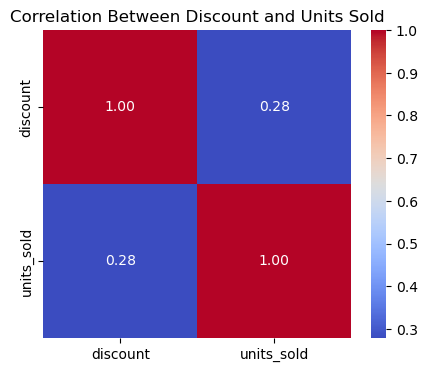

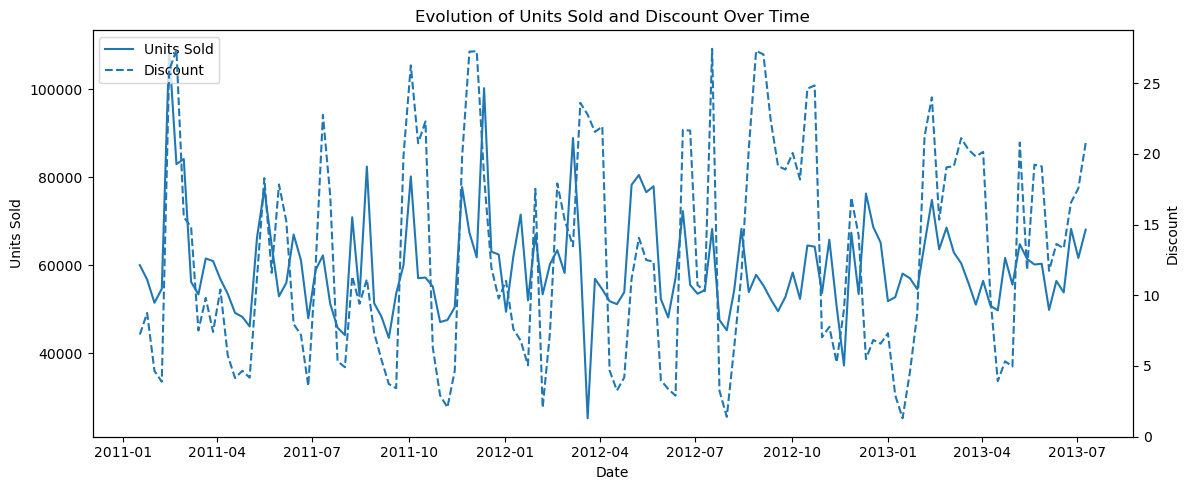

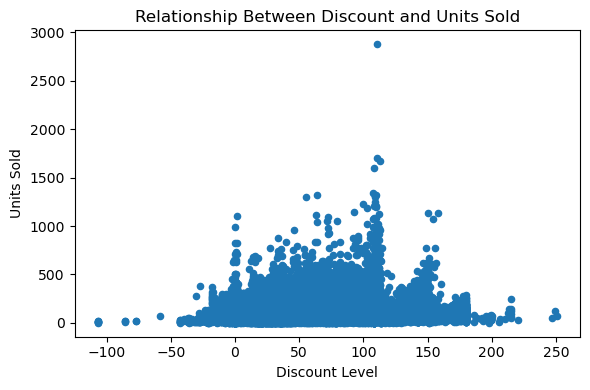

In [12]:
import seaborn as sns

corr = df[['discount', 'units_sold']].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Between Discount and Units Sold")
plt.show()

###################################""

# Aggregate weekly data
weekly_ts = (
    df.groupby('date')
      .agg({
          'units_sold': 'sum',
          'discount': 'mean'
      })
      .sort_index()
)

# Create plot
fig, ax1 = plt.subplots(figsize=(12,5))

# First curve: Units sold
ax1.plot(
    weekly_ts.index,
    weekly_ts['units_sold'],
    label='Units Sold'
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Units Sold")

# Second axis for discount
ax2 = ax1.twinx()
ax2.plot(
    weekly_ts.index,
    weekly_ts['discount'],
    linestyle='--',
    label='Discount'
)
ax2.set_ylabel("Discount")

# Title
plt.title("Evolution of Units Sold and Discount Over Time")

# Legend (combined)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()
#########################################""
df.plot.scatter(
    x='discount',
    y='units_sold',
    figsize=(6,4)
)

plt.xlabel("Discount Level")
plt.ylabel("Units Sold")
plt.title("Relationship Between Discount and Units Sold")

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Demand for Product 216418'}, xlabel='week'>

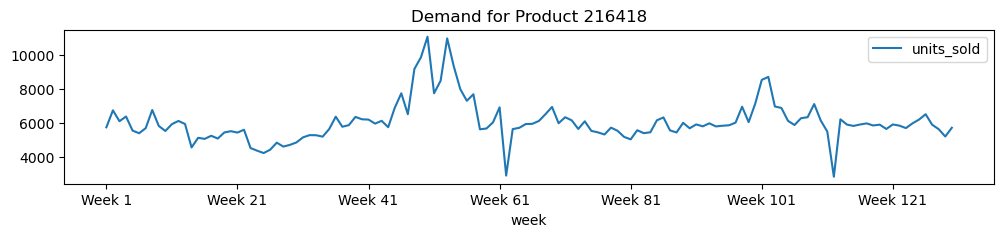

In [13]:
sample_product = df['product_id'].iloc[0]

product_ts = (
    df[df['product_id'] == sample_product]
      .groupby('week')['units_sold']
      .sum()
      .reset_index()
)

# Extract week number
product_ts['week_num'] = (
    product_ts['week']
    .str.extract(r'(\d+)')
    .astype(int)
)

# Sort correctly
product_ts = product_ts.sort_values('week_num')

product_ts.plot(
    x='week',
    y='units_sold',
    figsize=(12,2),
    title=f'Demand for Product {sample_product}'
)


# Forecasting Models

In [16]:
# ===============================
# 0. LIBRARIES
# ===============================


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error


In [17]:
# ===============================
# 1. DATA PREPARATION
# ===============================

# Ensure datetime format
df['date'] = pd.to_datetime(df['date'])

# Select top-selling product
top_product = (
    df.groupby('product_id')['units_sold']
      .sum()
      .sort_values(ascending=False)
      .index[0]
)

# Aggregate WEEKLY demand
ts = (
    df[df['product_id'] == top_product]
    .set_index('date')
    .resample('W')
    .sum()['units_sold']
    .asfreq('W')
)

# Retail-safe handling of missing weeks
ts = ts.fillna(0)

print(f"Forecasting product: {top_product}")
print(f"Total observations: {len(ts)}")


Forecasting product: 219009
Total observations: 130


In [18]:
# ===============================
# 2. TRAIN–TEST SPLIT (80/20)
# ===============================

train_size = int(len(ts) * 0.8)

train = ts.iloc[:train_size]
test  = ts.iloc[train_size:]

horizon = len(test)

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")


Train size: 104
Test size: 26


In [50]:
# ===============================
# 3. FORECASTING MODELS
# ===============================

# ---- Model 1: Naive ----
naive_forecast = pd.Series(
    train.iloc[-1],
    index=test.index
)

# ---- Model 2: Moving Average ----
# ---- Improved Moving Average (Rolling) ----
# ---- Seasonal Moving Average (52-week) ----
seasonal_window = 52

seasonal_ma_forecast = [
    train.iloc[-seasonal_window:].mean()
] * horizon

seasonal_ma_forecast = pd.Series(
    seasonal_ma_forecast,
    index=test.index
)



# ---- Model 3: ETS (Holt-Winters) ----
ets_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit(optimized=True)

ets_forecast = ets_model.forecast(horizon)
ets_forecast.index = test.index




# ---- Model 4: ARIMA ----
arima_model = ARIMA(
    train,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

arima_forecast = arima_model.forecast(horizon)
arima_forecast.index = test.index

# ---- Model 5: SARIMA ----
sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_forecast = sarima_model.forecast(horizon)
sarima_forecast.index = test.index


C:\Users\hibag\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hibag\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [51]:
# ===============================
# 4. EVALUATION METRICS
# ===============================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = pd.DataFrame({
    'Model': ['Naive', 'Moving Average', 'ETS', 'ARIMA', 'SARIMA'],
    'RMSE': [
        rmse(test, naive_forecast),
        rmse(test, ma_forecast),
        rmse(test, ets_forecast),
        rmse(test, arima_forecast),
        rmse(test, sarima_forecast)
    ],
    'MAPE (%)': [
        mape(test, naive_forecast),
        mape(test, ma_forecast),
        mape(test, ets_forecast),
        mape(test, arima_forecast),
        mape(test, sarima_forecast)
    ]
})

display(results)


,Model,RMSE,MAPE (%)
0,Naive,1632.740770,16.324099
1,Moving Average,1880.648230,25.207489
2,ETS,8082.595032,130.567546
3,ARIMA,2282.886554,35.245229
4,SARIMA,1619.650705,16.843306


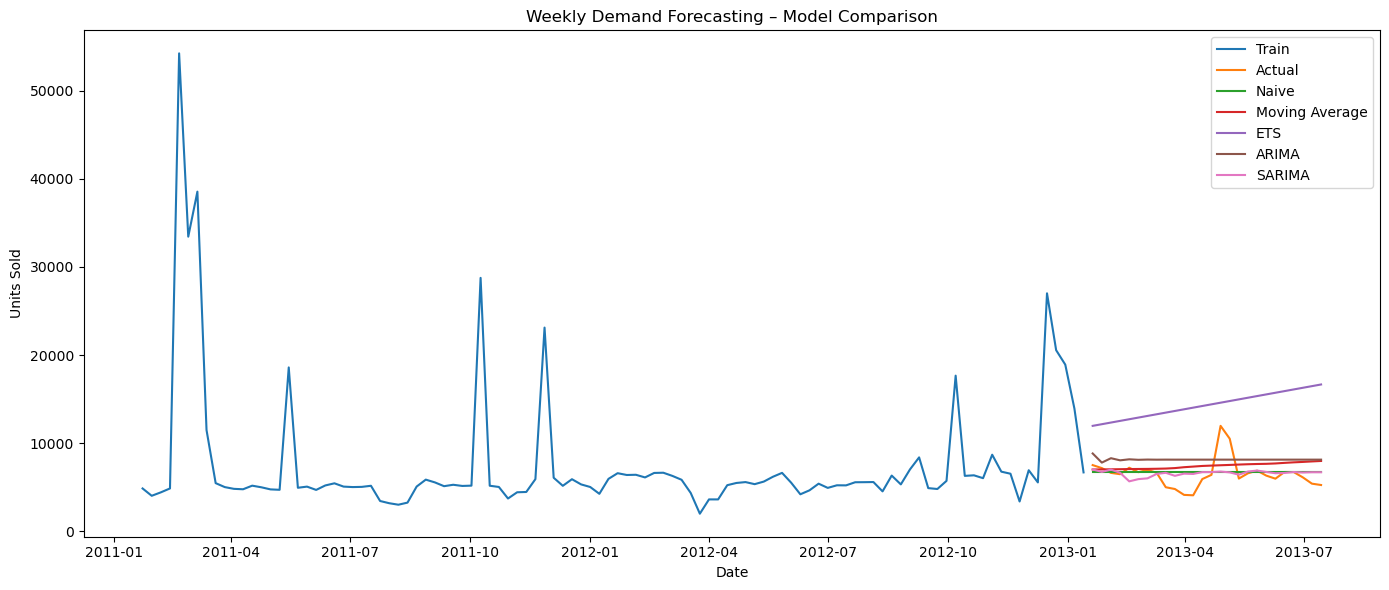

In [52]:
# ===============================
# 5. VISUALIZATION
# ===============================

plt.figure(figsize=(14, 6))

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')

plt.plot(test.index, naive_forecast, label='Naive')
plt.plot(test.index, ma_forecast, label='Moving Average')
plt.plot(test.index, ets_forecast, label='ETS')
plt.plot(test.index, arima_forecast, label='ARIMA')
plt.plot(test.index, sarima_forecast, label='SARIMA')

plt.title('Weekly Demand Forecasting – Model Comparison')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()


# Machine Learning-based time series forecasting

Machine Learning Forecasting Results


,Model,RMSE,MAPE (%)
0,Linear Regression,1681.059694,21.628054
1,Random Forest,4339.727198,28.840364
2,Gradient Boosting,4434.527672,26.116110


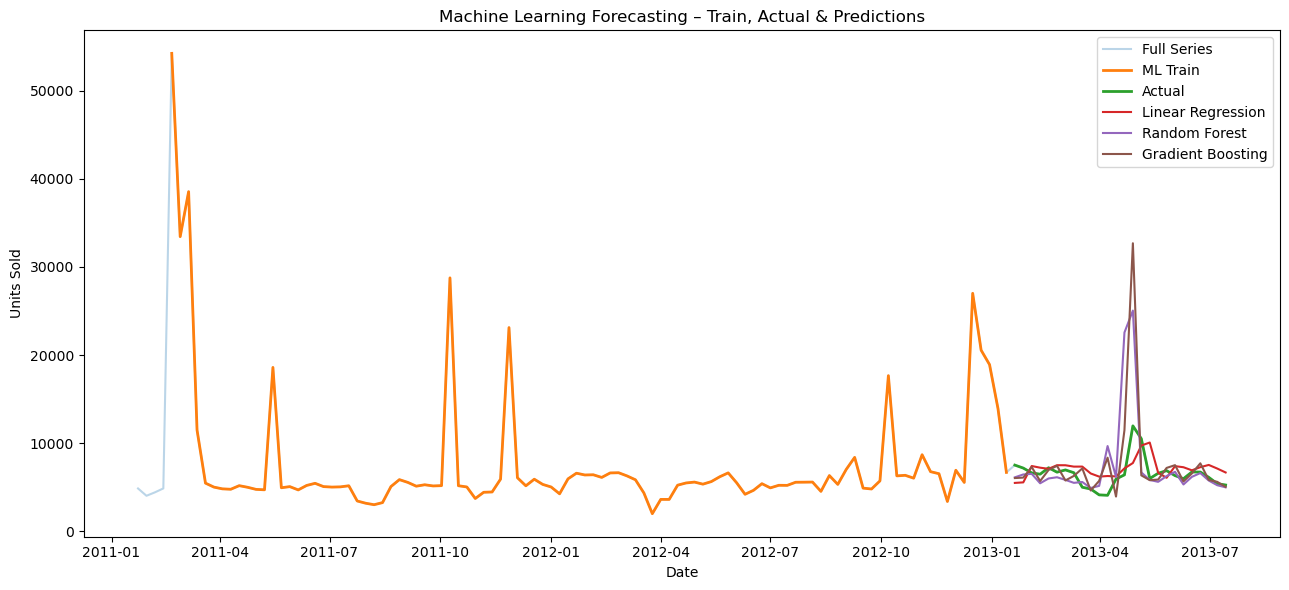

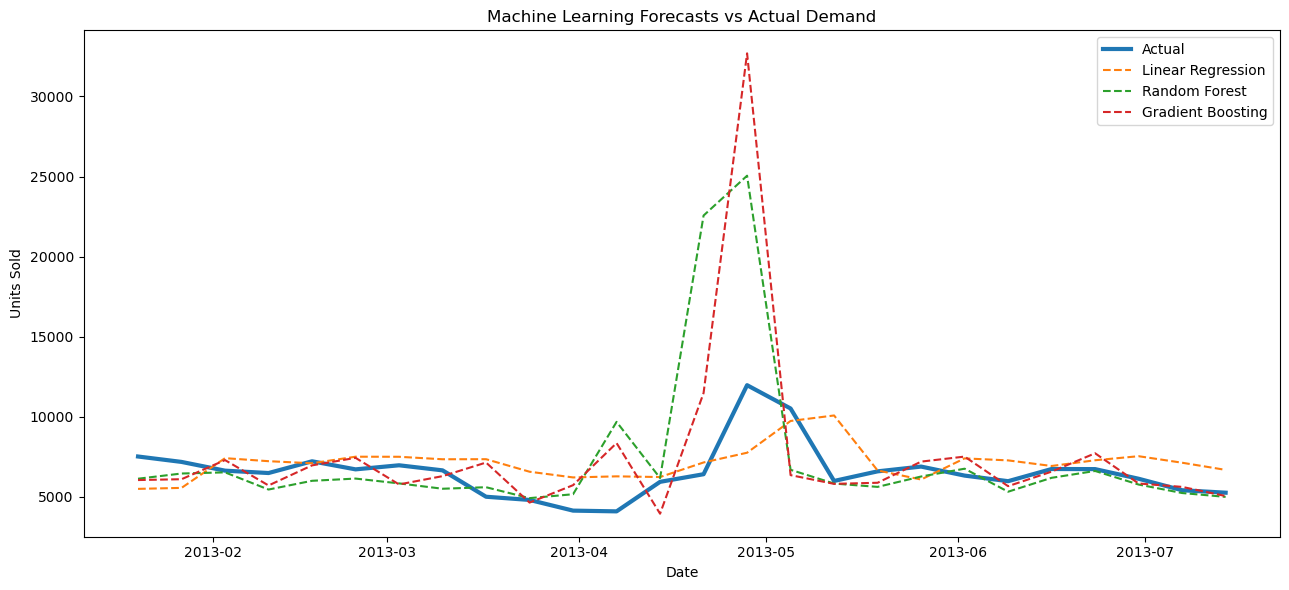

Train vs Test Evaluation Metrics


,Model,Train RMSE,Test RMSE,Train MAPE (%),Test MAPE (%)
0,Linear Regression,6703.360598,1681.059694,44.030241,21.628054
1,Random Forest,2961.048018,4339.727198,20.158593,28.840364
2,Gradient Boosting,770.532945,4434.527672,8.704147,26.116110


In [61]:
# ===============================
# MACHINE LEARNING FORECASTING
# ===============================

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ------------------------------
# 1. FEATURE ENGINEERING
# ------------------------------

ml_df = ts.to_frame(name='y')

# Lag features
ml_df['lag_1'] = ml_df['y'].shift(1)
ml_df['lag_2'] = ml_df['y'].shift(2)
ml_df['lag_3'] = ml_df['y'].shift(3)
ml_df['lag_4'] = ml_df['y'].shift(4)


# Drop missing values created by lags
ml_df = ml_df.dropna()

X = ml_df.drop(columns='y')
y = ml_df['y']

# ------------------------------
# 2. TRAIN–TEST SPLIT (TIME-AWARE)
# ------------------------------

train_size = int(len(ml_df) * 0.8)

X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

# ------------------------------
# 3. MODELS
# ------------------------------

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    )
}

ml_forecasts = {}
ml_results = []

# ------------------------------
# 4. TRAIN, PREDICT, EVALUATE
# ------------------------------

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    ml_forecasts[name] = preds

    ml_results.append({
        'Model': name,
        'RMSE': rmse(y_test, preds),
        'MAPE (%)': mape(y_test, preds)
    })

ml_results_df = pd.DataFrame(ml_results)

print("Machine Learning Forecasting Results")
display(ml_results_df)

plt.figure(figsize=(13,6))

# Plot full original series (context)
plt.plot(ts.index, ts, label='Full Series', alpha=0.3)

# Plot ML train target
plt.plot(
    y_train.index,
    y_train,
    label='ML Train',
    linewidth=2
)

# Plot ML test (actual)
plt.plot(
    y_test.index,
    y_test,
    label='Actual',
    linewidth=2
)

# Plot ML forecasts
for name, preds in ml_forecasts.items():
    plt.plot(
        y_test.index,
        preds,
        label=name
    )

plt.title('Machine Learning Forecasting – Train, Actual & Predictions')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

##############
plt.figure(figsize=(13,6))

# Plot actual values (test period only)
plt.plot(
    y_test.index,
    y_test,
    label='Actual',
    linewidth=3
)

# Plot ML forecasts
for name, preds in ml_forecasts.items():
    plt.plot(
        y_test.index,
        preds,
        label=name,
        linestyle='--'
    )

plt.title('Machine Learning Forecasts vs Actual Demand')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()
# ===============================
# TRAIN vs TEST METRICS (ML)
# ===============================

train_test_results = []

for name, model in models.items():
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    test_preds  = model.predict(X_test)
    
    # Metrics
    train_test_results.append({
        'Model': name,
        'Train RMSE': rmse(y_train, train_preds),
        'Test RMSE': rmse(y_test, test_preds),
        'Train MAPE (%)': mape(y_train, train_preds),
        'Test MAPE (%)': mape(y_test, test_preds)
    })

train_test_df = pd.DataFrame(train_test_results)

print("Train vs Test Evaluation Metrics")
display(train_test_df)

In [62]:
# ===============================
# MACHINE LEARNING FORECASTING
# ===============================

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# ===============================
# PART 1: LAG FEATURE ENGINEERING
# ===============================

ml_df = ts.to_frame(name='y')

# Create lag features
for lag in range(1, 5):
    ml_df[f'lag_{lag}'] = ml_df['y'].shift(lag)

# Drop missing values
ml_df = ml_df.dropna()

display(ml_df.head())


,y,lag_1,lag_2,lag_3,lag_4
date,,,,,
2011-02-20,54235,4873.0,4429.0,4039.0,4870.0
2011-02-27,33439,54235.0,4873.0,4429.0,4039.0
2011-03-06,38545,33439.0,54235.0,4873.0,4429.0
2011-03-13,11497,38545.0,33439.0,54235.0,4873.0
2011-03-20,5474,11497.0,38545.0,33439.0,54235.0


In [54]:
# ===============================
# PART 2: TIME-AWARE TRAIN–TEST SPLIT
# ===============================

X = ml_df.drop(columns='y')
y = ml_df['y']

train_size = int(len(ml_df) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training observations: {len(X_train)}")
print(f"Testing observations: {len(X_test)}")


Training observations: 100
Testing observations: 26


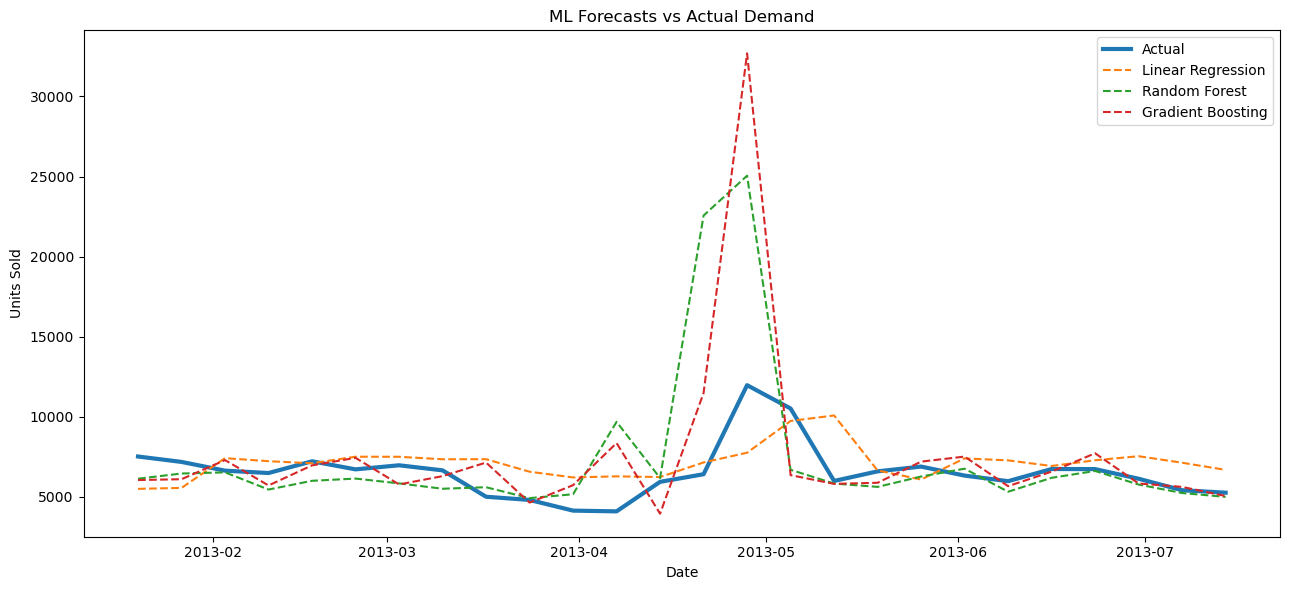

In [55]:
# ===============================
# PART 3: MODEL TRAINING & FORECASTS
# ===============================

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.05, random_state=42
    )
}

ml_forecasts = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    ml_forecasts[name] = model.predict(X_test)

# Plot results
plt.figure(figsize=(13,6))

plt.plot(y_test.index, y_test, label='Actual', linewidth=3)

for name, preds in ml_forecasts.items():
    plt.plot(y_test.index, preds, linestyle='--', label=name)

plt.title("ML Forecasts vs Actual Demand")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
# ===============================
# PART 4: EVALUATION METRICS
# ===============================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ml_results = []

for name, preds in ml_forecasts.items():
    ml_results.append({
        'Model': name,
        'RMSE': rmse(y_test, preds),
        'MAPE (%)': mape(y_test, preds)
    })

ml_results_df = pd.DataFrame(ml_results)
display(ml_results_df)


,Model,RMSE,MAPE (%)
0,Linear Regression,1681.059694,21.628054
1,Random Forest,4339.727198,28.840364
2,Gradient Boosting,4434.527672,26.116110
